# Device hamiltonian
Ricordiamo l'hamiltoniana di un quantum annealer

$$ \mathcal{H}_{\text{ising}} = - \frac{A(s)}{2} \left( \sum_i \hat{\sigma}_x^{(i)} \right) + \frac{B(s)}{2} \left( \sum_i h_i \hat{\sigma}_z^{(i)} + \sum_{i>j} J_{i,j} \hat{\sigma}_z^{(i)} \hat{\sigma}_z^{(j)} \right) $$

dove $A(s), B(s)$ dipendono dal device, mentre $h_i, J_{i,j}$ sono definiti dall'utente.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.read_excel('09-1192A-C_DW_2000Q_2_1_processor-annealing-schedule.xls', sheet_name=1)

In [2]:
df.head()

,s,A(s) (GHz),B(s) (GHz),C (normalized)
0,0.000,9.104432,0.066778,0.000000
1,0.001,9.045368,0.068383,0.004291
2,0.002,8.986803,0.070007,0.008533
3,0.003,8.929090,0.071649,0.012694
4,0.004,8.872295,0.073311,0.016768


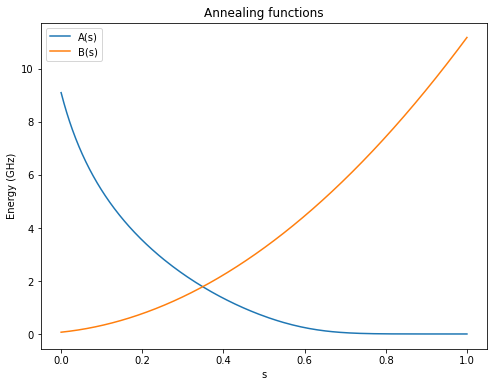

In [3]:
plt.figure(figsize=(8, 6))
plt.plot(df['s'], df['A(s) (GHz)'], label='A(s)')
plt.plot(df['s'], df['B(s) (GHz)'], label='B(s)')

plt.title('Annealing functions')
plt.xlabel('s')
plt.ylabel('Energy (GHz)')
plt.legend()
plt.show()

# Single qubit temperature measurements
Riducendosi a considerare un singolo spin, abbiamo libertà di scegliere $h$ e il parametro di annealing $s(t)$. $ \quad \forall i, j \quad J_{i,j}=0$

$$ \mathcal{H}_{\text{single qubit}} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z $$

In [4]:
# cerco quali device sono disponibili al momento
from dwave.cloud import Client

with Client.from_config() as client:
    for solver in client.get_solvers():
        print(solver.id)

hybrid_binary_quadratic_model_version2
hybrid_discrete_quadratic_model_version1
Advantage_system1.1
DW_2000Q_6


In [5]:
# scelgo il device e mi assicuro di poterci comunicare
from dwave.system import DWaveSampler

sampler = DWaveSampler(solver='DW_2000Q_6')
sampler.properties

{'num_qubits': 2048,
 'qubits': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  44,
  45,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,

### Quench for various times and h

L'idea è che facendo un veloce quench del qubit, questo vada più spesso nello stato ad alta energia perché guidato dall'*energia cinetica* dell'annealing, rispetto alla distribuzione che avrei andando lentamente (influenzata solo dal bagno termico).

Aspettando sufficiente tempo, lo stato evolve verso una situazione di equilibrio e campionando questa evoluzione riesco a descrivere il processo di termalizzazione.

In [14]:
# parametri
t_quench = 2.0
t_f = 20.0
h = 0.05

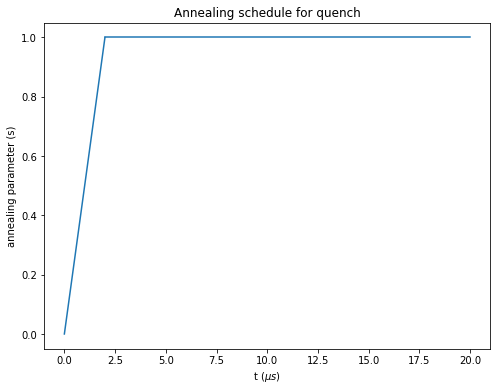

In [15]:
x0 = np.linspace(0, t_quench)
y0 = x0 / t_quench
x1 = np.linspace(t_quench, t_f)
y1 = np.ones(len(x1))

plt.figure(figsize=(8, 6))
plt.plot(x0, y0, color='C0')
plt.plot(x1, y1, color='C0')

plt.title('Annealing schedule for quench')
plt.xlabel('t ($\mu s$)')
plt.ylabel('annealing parameter (s)')
plt.show()

Tuttavia dopo il quench, la dinamica del qubit, governata da $A(t)$, evolve con tempi scala $t>>t_f=200\mu s$

Di conseguenza mi aspetto di non riuscire a vedere la termalizzazione

In [8]:
# campioniamo la termalizzazione per t_quench, t_f, h
 
linear_offsets = {active_node: h for active_node in sampler.nodelist}
quench_schedule = [[0.0, 0.0], [t_quench, 1.0], [t_f, 1.0]] 

sampler.validate_anneal_schedule(quench_schedule)
# sampleset = sampler.sample_ising(linear_offsets, {}, num_reads=10, anneal_schedule=quench_schedule, label=f'Quench test h={h}')

# print(sampleset)

### Classical approach: trivial reverse annealing

In maniera analoga, posso inizializzare il mio stato direttamente in un autostato di $\hat \sigma_z$ utilizzando il reverse annealing, e non modificare il parametro di annealing. Anche in questo caso mi aspetto che la dinamica di evoluzione (classica) si troppo lenta rispetto a $t_f$ e di non riuscire a vedere la termalizzazione.

In [2]:
# parametri
# t_quench = 2.0
t_f = 20.0
h = 0.05

In [ ]:
# campioniamo lo stato finale dell'evoluzione 'termica' di uno stato inizializzato lungo sigma_z
 
linear_offsets = {active_node: h for active_node in sampler.nodelist}
quench_schedule = [[0.0, 1.0], [t_f, 1.0]] 

sampler.validate_anneal_schedule(quench_schedule)
# sampleset = sampler.sample_ising(linear_offsets, {}, num_reads=10, anneal_schedule=quench_schedule, label=f'Quench test h={h}')

print(sampleset)

### Official docs

Per trovare i **freezout points** bisogna capire quando il tempo scala della dinamica di un qubit (A(s)) diventa maggiore di $t_f$.

 dalla quale posso inferire la temperatura (conosco la differenza energetica dei livelli da B(s) e h).

# Entanglement creation